### Instrukcje

Tym razem zadanie polega na stworzeniu klasyfikatora obrazków działającego na 50 klasach z różnymi przedmiotami/zwierzętami itp. Do dyspozycji mają Państwo zbiór treningowy podzielony na odpowiednie podfoldery z klasami oraz zbiór testowy - bez podziału. Zbiór treningowy jest przygotowany w taki sposób by można go było łatwo załadować za pomocą klasy torchvision.ImageFolder wywołując np:
trainset = ImageFolder("data/train/", transform=train_transform)
Wówczas wszystkie przykłady zostaną przypisane do odpowiedniej klasy w zależności od tego w jakim podfolderze się znajdowały.
Jako że dane są bardzo duże to umieściłem je na OneDrive:
(train.zip i test_all.zip)

Proszę zwrócić szczególną uwagę na formę zwracanego rozwiązania, bo ostatnio większość z państwa zrobiła to byle jak i miałem bardzo dużo problemów z dodawaniem/usuwaniem niepotrzebnych wierszy itp. Tym razem nie będę poprawiał przesyłanych przez Państwa plików tylko wpisywał 0% accuracy!
W ramach rozwiązania, proszę oddać przez teamsy plik archiwum .zip z kodem (w formie notebooka, lub skryptu/skryptów .py) oraz plikiem .csv z predykcjami na zbiorze testowym. BEZ dodatkowych podfolderów i BEZ danych. W ramach predykcji proszę zapisać tym razem dwie kolumny (bez nagłówków):
Pierwszą kolumnę z nazwami plików testowych (uwaga pliki nazywają się np. 850043533599308.JPEG a nie 850043533599308.jpeg, 850043533599308.jpg czy 850043533599308). Proszę zwrócić na to uwagę bo mój skrypt ewaluacyjny inaczej nie zadziała.
Drugą kolumnę z wartościami oznaczającą predykcję numeru klasy. Klasy ponumerowane są zgodnie z numeracją ze zbioru treningowego (alfabetycznie startując od zera). Po utworzeniu datasetu w oparciu o ImageFolder klasy powinny się tak przypisać autoamtycznie - mogą to państwo sprawdzić wywołując trainset.classes.
Bardzo proszę nazywać wszystkie przesyłane pliki nazwiskami autorów (najlepiej alfabetycznie). Wyszukiwanie kto podpisał się "predictions.csv", a kto projekt_2.ipynb jest uciążliwe. Nazwę głównego archiwum zip, proszę dodatkowo rozpocząć od przedrostka poniedzialek_ lub piatek_, NIE pn,ptk albo coś w tym stylu.
Końcowe wyniki obliczał będę w oparciu o zwykłe accuracy (klasy są zbilansowane).
Uwaga: W zadaniu proszę nie wykorzystywać gotowych architektur o których wspominałem na zajęciach. Proszę też nie kopiować gotowych fragmentów (np. bloki resnetowe itp). Ostatnie laboratorium poświęcone będzie dokładnie temu zagadnieniu.

W MS Teams przydzieliłem zadanie wszystkim uczestnikom, ale bardzo proszę żeby tylko jeden (dowolny) członek zespołu je zwrócił (proszę się dogadać).
W razie pytań zapraszam do korespondencji lub na konsultacje.

# K. Deja w 50 epok - ~50% accuracy na prostym modelu

Jeden zespół w zeszłym semie miał 70%

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns

import torch, torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.sampler import SubsetRandomSampler

import torch.utils.data as data
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device("cuda")

if torch.cuda.is_available():
    torch.cuda.manual_seed(500)
    torch.cuda.manual_seed_all(500)
torch.manual_seed(500)
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False
device

device(type='cuda')

## Mount Google Drive

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Prepare runtime directory and unzip data

In [ ]:
!mkdir data/test && unzip /content/drive/MyDrive/colab/train.zip -d data/ && unzip /content/drive/MyDrive/colab/test_all.zip -d data/test/

## Read data

In [3]:
transform_orig = transforms.Compose(
    [transforms.ToTensor()]
)

dataset_no_aug = torchvision.datasets.ImageFolder("data/train/", transform=transform_orig)

### Augment data to get more training examples

In [4]:
transform_aug = transforms.Compose(
    [transforms.RandomRotation(25),
     transforms.RandomHorizontalFlip(0.5),
     transforms.RandomVerticalFlip(0.5),
     transforms.ToTensor(),
     transforms.RandomErasing(0.5),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

dataset_aug = torchvision.datasets.ImageFolder("data/train/", transform=transform_aug)
dataset = torch.utils.data.ConcatDataset([dataset_no_aug, dataset_aug])

### Get training and validation sets

In [10]:
VALIDATION_SET_RATIO = 0.15
dataset_indices = list(range(len(dataset)))
np.random.shuffle(dataset_indices)
valid_split_index = int(np.floor(VALIDATION_SET_RATIO * len(dataset)))

train_idx, val_idx = dataset_indices[valid_split_index:], dataset_indices[:valid_split_index]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(val_idx)

In [11]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, sampler=valid_sampler)

### Dataset classes

In [12]:
classes = dataset_no_aug.classes
(len(classes), classes)

(50,
 ['acoustic',
  'antenna',
  'bacteria',
  'battery',
  'bean',
  'beetle',
  'bicycle',
  'birch',
  'bird',
  'bomb',
  'bread',
  'bridge',
  'camera',
  'carbon',
  'cat',
  'corn',
  'crab',
  'crocodilian',
  'echinoderm',
  'egg',
  'elephant',
  'fish',
  'flower',
  'frog',
  'fungus',
  'gauge',
  'hammer',
  'icecream',
  'kangaroo',
  'memorial',
  'monkey',
  'motor',
  'nest',
  'palm',
  'pizza',
  'pot',
  'printer',
  'saw',
  'snake',
  'spice',
  'spider',
  'spoon',
  'squash',
  'swine',
  'tea',
  'tomato',
  'towel',
  'truck',
  'turtle',
  'worm'])

## Some example images

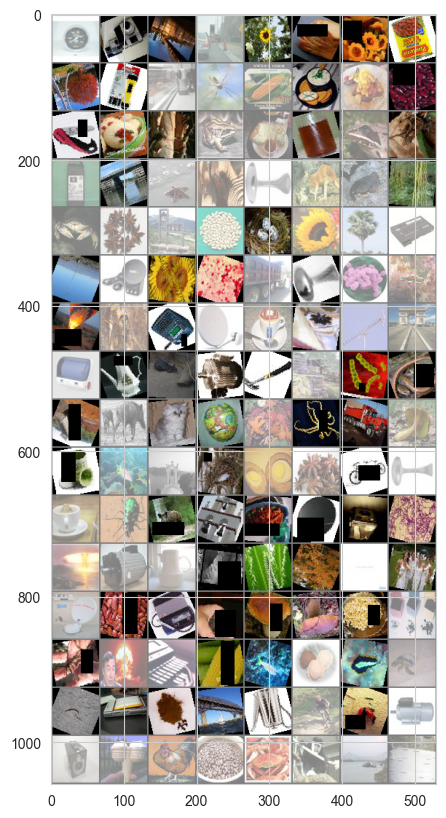

In [13]:
plt.figure(figsize = (5, 10))


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, labels = next(iter(train_loader))

imshow(torchvision.utils.make_grid(images))

## Convolutional neural network

In [14]:
next(iter(train_loader))[0].shape

torch.Size([128, 3, 64, 64])

In [15]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=50, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(50)
        self.d1 = nn.Dropout(0.5)

        self.conv2 = nn.Conv2d(in_channels=50, out_channels=75, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(75)
        self.d2 = nn.Dropout(0.5)

        self.conv3 = nn.Conv2d(in_channels=75, out_channels=100, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(100)
        self.d3 = nn.Dropout(0.5)

        self.conv4 = nn.Conv2d(in_channels=100, out_channels=150, kernel_size=1)
        self.bn4 = nn.BatchNorm2d(150)
        self.d4 = nn.Dropout(0.5)

        self.conv5 = nn.Conv2d(in_channels=150, out_channels=200, kernel_size=2)
        self.bn5 = nn.BatchNorm2d(200)
        self.d5 = nn.Dropout(0.5)

        self.conv6 = nn.Conv2d(in_channels=200, out_channels=300, kernel_size=2)
        self.bn6 = nn.BatchNorm2d(300)
        self.d6 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(6*6*300, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 50)

    def forward(self, x):
        x = self.d1(self.bn1(F.relu(self.conv1(x))))
        x = self.d2(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(x)

        x = self.d3(self.bn3(F.relu(self.conv3(x))))
        x = self.d4(self.bn4(F.relu(self.conv4(x))))
        x = self.pool(x)

        x = self.d5(self.bn5(F.relu(self.conv5(x))))
        x = self.d6(self.bn6(F.relu(self.conv6(x))))
        x = self.pool(x)

        # print(x.shape)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        x = self.fc4(x)
        return x

net = Network().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [ ]:
N_EPOCHS = 30

for epoch in range(N_EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f'[{epoch+1}/{N_EPOCHS}] loss: {running_loss / len(train_loader):.5f}')

[1/30] loss: 3.03628


## Results

### Accuracy on training and validation sets

In [ ]:
def get_accuracy(loader, b_size):
    correct = 0
    total = 0
    all_outs = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            outputs = net(images).cpu()
            _, predicted = torch.max(outputs.data, 1)
            all_outs.extend(predicted.tolist())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total, all_outs 

In [ ]:
acc_train, all_outs_train = get_accuracy(train_loader, BATCH_SIZE)
acc_valid, all_outs_valid = get_accuracy(valid_loader, BATCH_SIZE)

print(f'Accuracy of the network on the training set: {acc_train:.2f}%.')
print(f'Accuracy of the network on the validation set: {acc_valid:.2f}%.')

### Accuracy for each class

In [27]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        images = images.to(device)
        outputs = net(images).cpu()
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

min_acc = 100.0
min_acc_classes = []
max_acc = 0.0
max_acc_classes = []

for classname, correct_count in correct_pred.items():
    acc = 100 * float(correct_count) / total_pred[classname]
    if acc <= min_acc:
        if acc == min_acc:
            min_acc_classes.append(classname)
        else:
            min_acc = acc
            min_acc_classes = [classname,]
    elif acc >= max_acc:
        if acc == max_acc:
            max_acc_classes.append(classname)
        else:
            max_acc = acc
            max_acc_classes = [classname,]
    print(f'Accuracy for class {classname}: {acc:.2f}%.')

print(f'\nMin accuracy {min_acc:.2f}% for class(es): {min_acc_classes}.')
print(f'Max accuracy {max_acc:.2f}% for class(es): {max_acc_classes}.')

Accuracy for class acoustic: 52.85%.
Accuracy for class antenna: 68.64%.
Accuracy for class bacteria: 65.93%.
Accuracy for class battery: 59.85%.
Accuracy for class bean: 60.00%.
Accuracy for class beetle: 79.13%.
Accuracy for class bicycle: 75.66%.
Accuracy for class birch: 56.30%.
Accuracy for class bird: 49.35%.
Accuracy for class bomb: 62.85%.
Accuracy for class bread: 50.30%.
Accuracy for class bridge: 69.87%.
Accuracy for class camera: 76.84%.
Accuracy for class carbon: 56.83%.
Accuracy for class cat: 65.16%.
Accuracy for class corn: 65.38%.
Accuracy for class crab: 56.47%.
Accuracy for class crocodilian: 61.43%.
Accuracy for class echinoderm: 53.82%.
Accuracy for class egg: 53.82%.
Accuracy for class elephant: 72.79%.
Accuracy for class fish: 60.69%.
Accuracy for class flower: 90.80%.
Accuracy for class frog: 60.45%.
Accuracy for class fungus: 75.57%.
Accuracy for class gauge: 57.72%.
Accuracy for class hammer: 80.19%.
Accuracy for class icecream: 60.82%.
Accuracy for class kang

### Average accuracy for classes

In [28]:
sum_acc = 0
for classname, correct_count in correct_pred.items():
    sum_acc += 100 * float(correct_count) / total_pred[classname]
print(f'Validation set average classes accuracy: {sum_acc/50:.2f}%.')

Validation set average classes accuracy: 65.31%.


## Results for test set

In [47]:
test_dataset = torchvision.datasets.ImageFolder('data/test/', transform=transform_orig)

In [49]:
test_set_pred = []
net.eval()
with torch.no_grad():
    for idx, x in enumerate(test_dataset):
        x = x[0].to(device).unsqueeze(0)
        predicted_val = net(x).cpu()
        _, predicted = torch.max(predicted_val.data, 1)
        row = (test_dataset.imgs[idx][0].lstrip(r'data/test/test_all\\'), predicted.item())
        test_set_pred.append(row)

df = pd.DataFrame(test_set_pred)
df

,0,1
0,00013066837824360356.JPEG,38
1,00022240850406751722.JPEG,31
2,0004927347689911432.JPEG,46
3,000563265767796084.JPEG,39
4,0006013938786831874.JPEG,45
...,...,...
9995,9996231273861222.JPEG,12
9996,9996908958438282.JPEG,25
9997,9997674427283424.JPEG,31
9998,9997698258014044.JPEG,35


### Save results to csv

In [53]:
csv = df.to_csv(index=False, header=False)
with open('results.csv', 'w', newline="") as fh:
    fh.write(csv)

### Example predictions

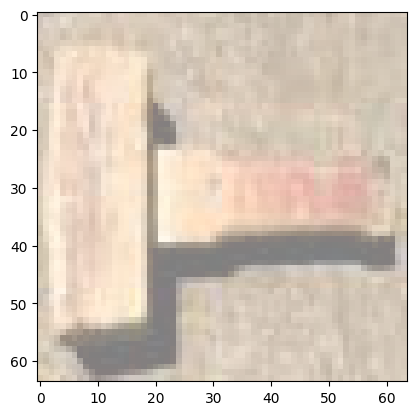

snake


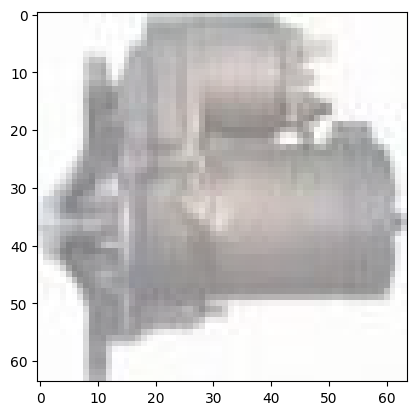

motor


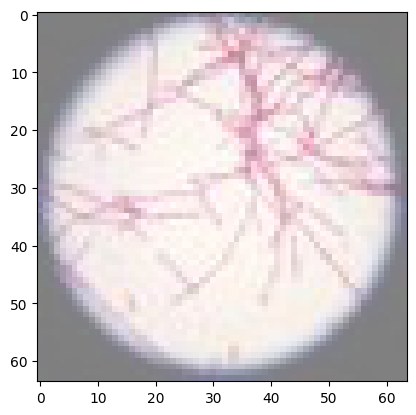

towel


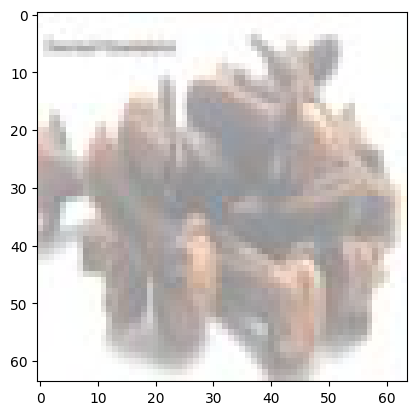

spice


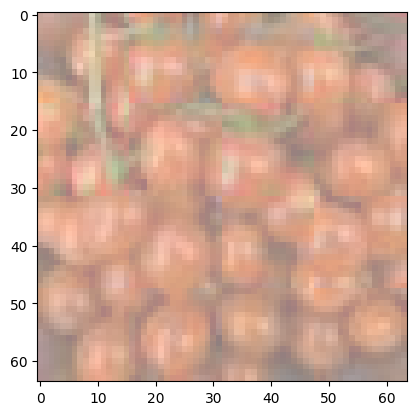

tomato


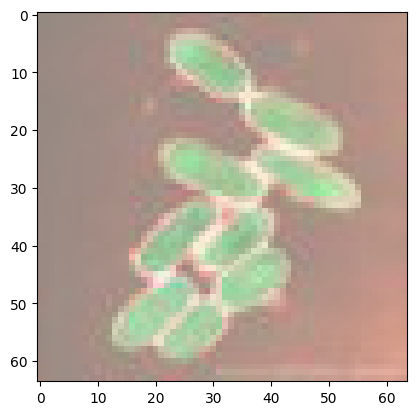

bacteria


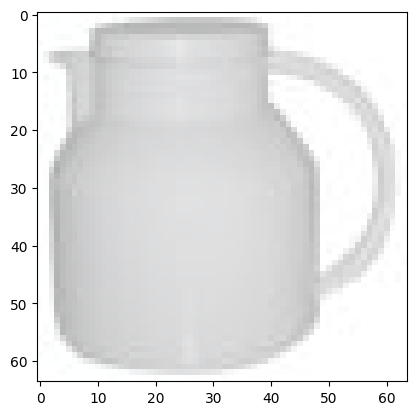

antenna


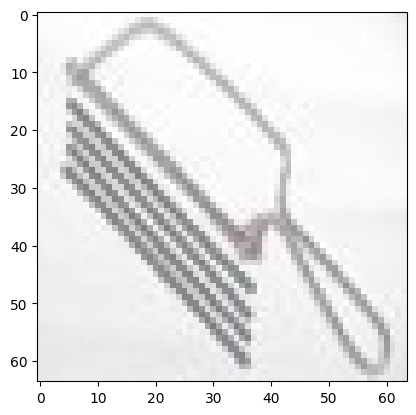

saw


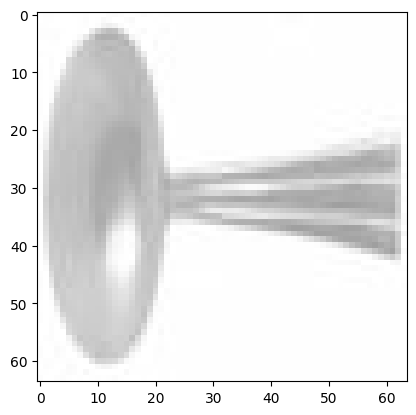

spoon


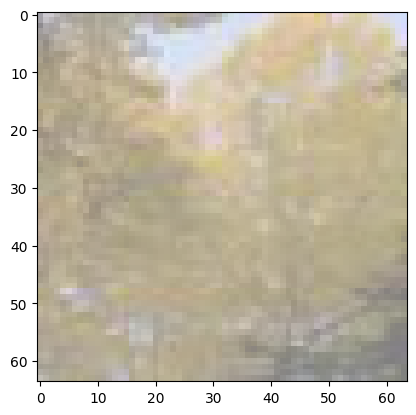

birch


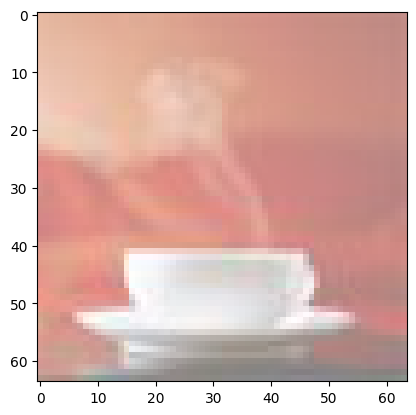

bacteria


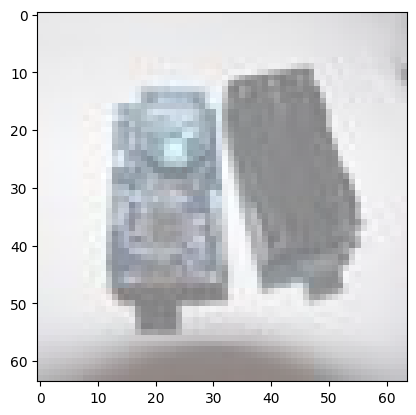

camera


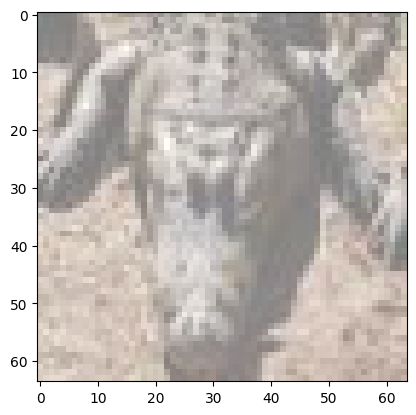

swine


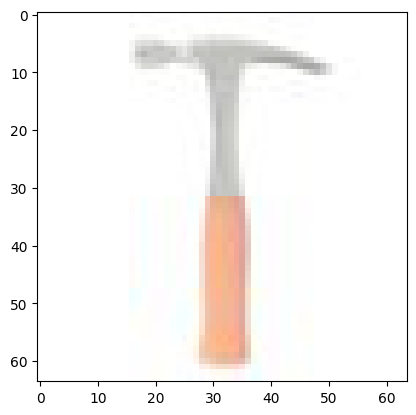

hammer


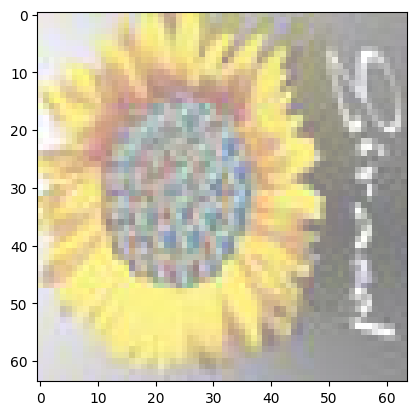

flower


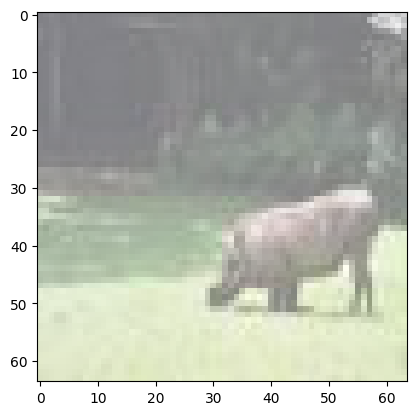

elephant


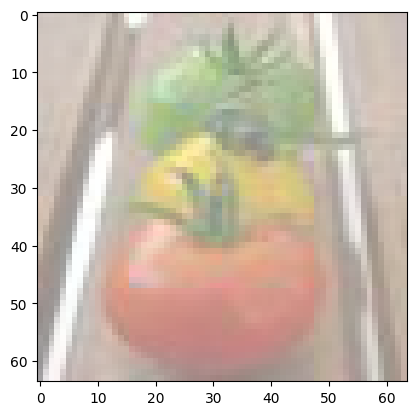

tomato


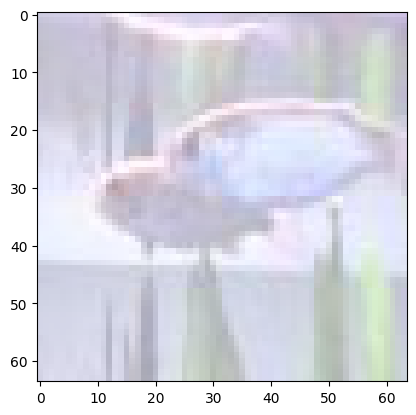

motor


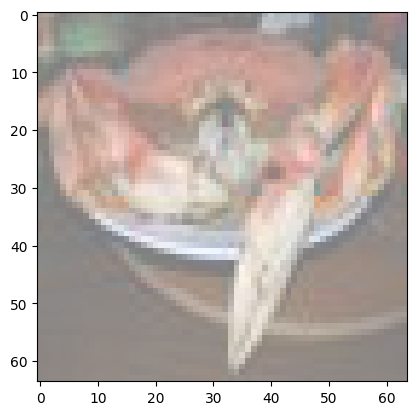

icecream


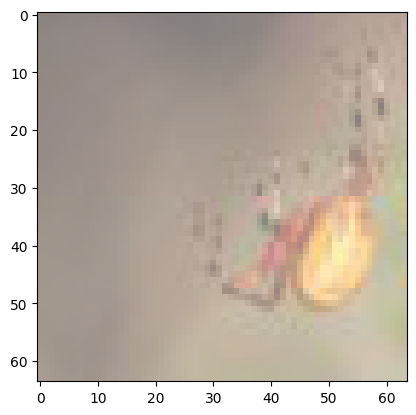

squash


In [54]:
for i in range(20):
    imshow(test_dataset[i][0])
    print(classes[test_set_pred[i][1]])